# Bitcoin price prediction  

Starting a new quick project, let's try to write a time series prediction for the bitcoin price.
Let's take a small dataset from some past, try to achieve the smallest MAE for linear regression.

## 1. Import data, packets

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp'
                  )

display(data.head())
data.info()

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4608 entries, 2023-06-18 00:00:00 to 2023-07-03 23:55:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4608 non-null   float64
 1   high    4608 non-null   float64
 2   low     4608 non-null   float64
 3   close   4608 non-null   float64
 4   volume  4608 non-null   float64
dtypes: float64(5)
memory usage: 216.0 KB


Let's look at open price graph.

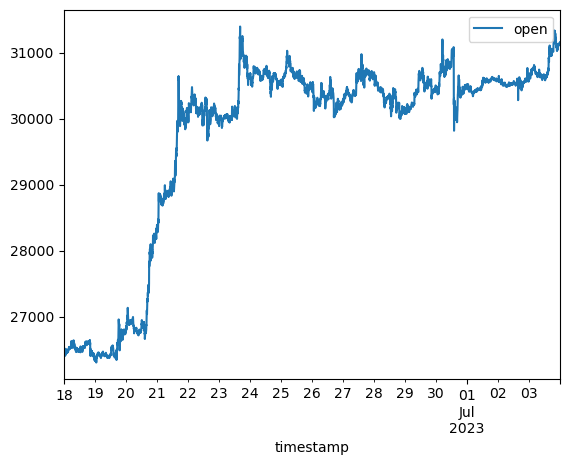

In [2]:
data = data[['open']]
data.plot();

## 2. Data Preprocessing

So prediction the open price be our goal.  
First of all we need to clean dataframe from NaN values, chech index order and create addition features.  
Let's do it at separated steps, and merge them after the check.  

### 2.1 Data checks

In [3]:
# check index for monotonic
data.index.is_monotonic_increasing

True

In [4]:
# check for NaN
data.isna().sum()

open    0
dtype: int64

### 2.2 Create additional features

In [5]:
# time lags
lag_start = 5
lag_end = 20

df_w = pd.DataFrame(data.copy())

for i in range(lag_start, lag_end):
    df_w[f'lag_{i}'] = df_w['open'].shift(i)

# delete NaN    
df_w.dropna(inplace=True)
    
df_w.head(15)

,open,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
timestamp,,,,,,,,,,,,,,,,
2023-06-18 01:35:00,26440.09,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30,26508.01,26519.10
2023-06-18 01:40:00,26472.00,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30,26508.01
2023-06-18 01:45:00,26457.37,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44,26511.30
2023-06-18 01:50:00,26459.88,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33,26519.44
2023-06-18 01:55:00,26478.14,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12,26513.33
2023-06-18 02:00:00,26506.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27,26437.12
2023-06-18 02:05:00,26492.51,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69,26477.27
2023-06-18 02:10:00,26489.81,26457.37,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93,26442.69
2023-06-18 02:15:00,26488.21,26459.88,26457.37,26472.00,26440.09,26450.30,26432.68,26430.32,26424.30,26445.92,26440.58,26442.69,26430.23,26413.75,26404.98,26447.93


## 3. Baseline Regreshion model

In [6]:
# split the dataframe to train and test assets
y = df_w['open']
X = df_w.drop('open', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=12345)

CPU times: user 14.6 ms, sys: 3.97 ms, total: 18.5 ms
Wall time: 17.2 ms


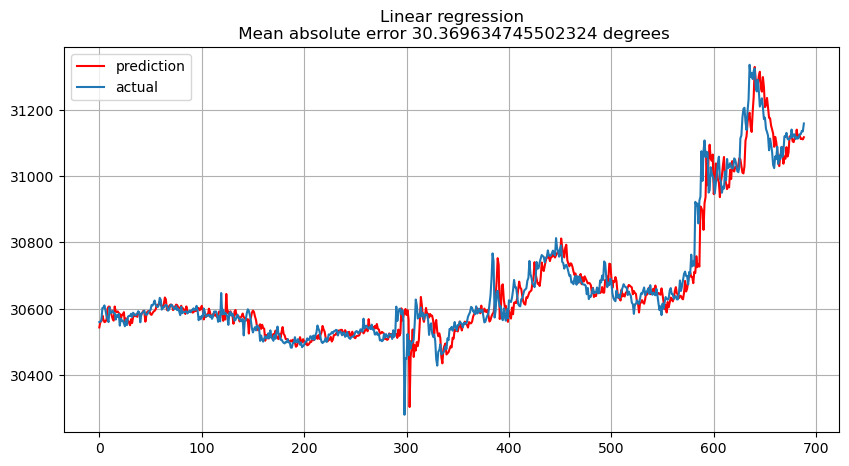

In [7]:
%%time

# declare the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(y_pred, y_test)} degrees");

## 4. Upgrade model

### 4.1 Cross-Validation

In [8]:
# cancatinate train and test data sets for more efficient use of cross validation
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [9]:
%%time

tscv = TimeSeriesSplit(n_splits=10)
regressor = LinearRegression()
print('# Train Linear Regression for mean_absolute_error #')
print()
cv_mae_lr = (cross_val_score(regressor, 
                             X, 
                             y, 
                             cv=tscv, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of Linear Regression =', cv_mae_lr)

# Train Linear Regression for mean_absolute_error #

Mean MAE from CV of Linear Regression = 61.86599630746016
CPU times: user 24.6 ms, sys: 3.9 ms, total: 28.5 ms
Wall time: 25.8 ms


As we can see, just cross validation is not enough, and the result has only gotten worse. Need to create the new attributes.

### 4.2 Adding aggregated features

In [ ]:
# let's add a ratio between the next and the previous steps
df_w['prev_step_rat'] = df_w['open'] / df_w['open'].shift()

# add mean for 3 steps by rolling window
df_w['rw_mean'] = df_w['open'].shift().rolling(3).mean()

# add day, weekday average and hour average
df_w['date'] = df_w.index.day
df_w['weekday'] = df_w.index.weekday
df_w['hour'] = df_w.index.hour

# we will use pivot tables to calculate the averaged features, so it is best to describe the steps here, 
# and below we will convert the preprocessing phase into a single function for convenience.

test_size = 0.15 # size of the test asset
ts_cut = df_w.iloc[math.ceil(len(df_w.index.to_list())*(1-test_size))].name

'''
# the long one line above is need to find out timestamp for train_test_split

idx_list = df_w.index.to_list()
idx_cut = math.ceil(len(idx_list)*(1-test_size))
ts_cut = df_w.iloc[idx_cut].name
'''

# to prevent data leaks from the future, we use only the training set to calculate the aggregate data
hour_mean = df_w[:ts_cut].pivot_table(index='hour', values='open', aggfunc=['mean'])
hour_mean.columns = ['mean']
display(hour_mean.head())

for hour in hour_mean.index:
    df_w.loc[(df_w['hour'] == hour), 'hour_mean'] = hour_mean.loc[hour, 'mean']
    
df_w.dropna(inplace=True)

display(df_w.head(10))
df_w.info()

,mean
hour,
0,29633.488526
1,29661.611923
2,29531.960610
3,29482.867083
4,29502.868393


,open,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,...,lag_16,lag_17,lag_18,lag_19,prev_step_rat,rw_mean,date,weekday,hour,hour_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-18 02:35:00,26469.42,26489.81,26492.51,26506.00,26478.14,26459.88,26457.37,26472.00,26440.09,26450.30,...,26424.30,26445.92,26440.58,26442.69,1.000546,26470.510000,18,6,2,29531.960610
2023-06-18 02:40:00,26458.42,26488.21,26489.81,26492.51,26506.00,26478.14,26459.88,26457.37,26472.00,26440.09,...,26430.32,26424.30,26445.92,26440.58,0.999584,26466.090000,18,6,2,29531.960610
2023-06-18 02:45:00,26460.65,26482.68,26488.21,26489.81,26492.51,26506.00,26478.14,26459.88,26457.37,26472.00,...,26432.68,26430.32,26424.30,26445.92,1.000084,26460.940000,18,6,2,29531.960610
2023-06-18 02:50:00,26468.89,26473.87,26482.68,26488.21,26489.81,26492.51,26506.00,26478.14,26459.88,26457.37,...,26450.30,26432.68,26430.32,26424.30,1.000311,26462.830000,18,6,2,29531.960610
2023-06-18 02:55:00,26470.25,26454.98,26473.87,26482.68,26488.21,26489.81,26492.51,26506.00,26478.14,26459.88,...,26440.09,26450.30,26432.68,26430.32,1.000051,26462.653333,18,6,2,29531.960610
2023-06-18 03:00:00,26469.54,26469.42,26454.98,26473.87,26482.68,26488.21,26489.81,26492.51,26506.00,26478.14,...,26472.00,26440.09,26450.30,26432.68,0.999973,26466.596667,18,6,3,29482.867083
2023-06-18 03:05:00,26469.87,26458.42,26469.42,26454.98,26473.87,26482.68,26488.21,26489.81,26492.51,26506.00,...,26457.37,26472.00,26440.09,26450.30,1.000012,26469.560000,18,6,3,29482.867083
2023-06-18 03:10:00,26483.82,26460.65,26458.42,26469.42,26454.98,26473.87,26482.68,26488.21,26489.81,26492.51,...,26459.88,26457.37,26472.00,26440.09,1.000527,26469.886667,18,6,3,29482.867083
2023-06-18 03:15:00,26490.10,26468.89,26460.65,26458.42,26469.42,26454.98,26473.87,26482.68,26488.21,26489.81,...,26478.14,26459.88,26457.37,26472.00,1.000237,26474.410000,18,6,3,29482.867083


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4577 entries, 2023-06-18 02:35:00 to 2023-07-03 23:55:00
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           4577 non-null   float64
 1   lag_5          4577 non-null   float64
 2   lag_6          4577 non-null   float64
 3   lag_7          4577 non-null   float64
 4   lag_8          4577 non-null   float64
 5   lag_9          4577 non-null   float64
 6   lag_10         4577 non-null   float64
 7   lag_11         4577 non-null   float64
 8   lag_12         4577 non-null   float64
 9   lag_13         4577 non-null   float64
 10  lag_14         4577 non-null   float64
 11  lag_15         4577 non-null   float64
 12  lag_16         4577 non-null   float64
 13  lag_17         4577 non-null   float64
 14  lag_18         4577 non-null   float64
 15  lag_19         4577 non-null   float64
 16  prev_step_rat  4577 non-null   float64
 17  rw_mean        4

### 4.3 Prepeocessing optimization

In [ ]:
# function for calculation mean values for different time intervals
def time_int_mean(df, ts_cut):
    df_func2 = df.copy()
    
    df_func2['hour'] = df_func2.index.hour
    df_func2['date'] = df_func2.index.day
    df_func2['weekday'] = df_func2.index.weekday
    
    for time_int in ['hour','date','weekday']:
        mean_val_table = df_func2[:ts_cut].pivot_table(index=time_int, values='open', aggfunc=['mean'])
        mean_val_table.columns = ['mean']

        for idx in mean_val_table.index:
            df_func2.loc[(df[time_int] == idx), str(time_int+'_mean')] = mean_val_table.loc[idx, 'mean']
            
    return df_func2

In [ ]:
# function for preprocessing procedure
def preprocessing_func(df, min_lag=5, max_lag=20, test_size=0.15):
    df_func = df.copy()
    
    for i in range(min_lag, max_lag):
        df_func[f'lag_{i}'] = df_func['open'].shift(i)
        
    df_func['prev_step_rat'] = df_func['open'] / df_func['open'].shift()
    df_func['rw_mean'] = df_func['open'].shift().rolling(3).mean()

    test_size = 0.15
    ts_cut = df_w.iloc[math.ceil(len(df_w.index.to_list())*(1-test_size))].name
    
    df_func = time_int_mean(df_func, ts_cut)
        
    df_func.dropna(inplace=True)

    # separate train and test assets
    X_train = df_func.loc[:ts_cut].drop(['open'], axis=1)
    y_train = df_func.loc[:ts_cut]['open']
    X_test = df_func.loc[ts_cut:].drop(['open'], axis=1)
    y_test = df_func.loc[ts_cut:]['open']
    
    return X_train, X_test, y_train, y_test